In [1]:
import sys
sys.path.append('../../')
import cv2
import numpy as np
import matplotlib.pyplot as plt

from rover_simulator.world import World
from rover_simulator.rover import BasicRover
from rover_simulator.history import SimpleHistory
from rover_simulator.navigation.controller import ConstantSpeedController
from rover_simulator.navigation.mapper import GridMapper
# https://emotionexplorer.blog.fc2.com/blog-entry-398.html

In [62]:
world = World()
world.read_objects("../../rover_simulator/examples/environment_simple.txt")

rover_r = 0.5
start_pose = np.array([1.0, 1.0, 0.0])
goal_pos = np.array([13.0, 15.0])

mapper = GridMapper(
    grid_size=np.array([20, 20]),
    grid_width=0.5,
    sensor=None,
    known_obstacles=world.obstacles,
    rover_r=rover_r
)

path_planner = None

rover = BasicRover(
    start_pose, rover_r,
    sensor=None,
    mapper=mapper,
    path_planner=path_planner,
    localizer=None,
    controller=ConstantSpeedController(w=np.pi/32),
    history=SimpleHistory()
)

world.append_rover(rover)

In [63]:
from rover_simulator.utils.draw import draw_grid_map, set_fig_params

# fig, ax = set_fig_params((16, 16), [0, 20], [0, 20])
# extent = (
#     -mapper.grid_width / 2,
#     mapper.grid_width * mapper.grid_num[0] - mapper.grid_width / 2,
#     -mapper.grid_width / 2, mapper.grid_width * mapper.grid_num[1] - mapper.grid_width / 2
# )

v_map = np.zeros(mapper.map.shape)
idx = np.where(mapper.map > 0.9)
v_map[idx] = 1.0
# draw_grid_map(ax, v_map, "Greys", 0.0, 1.0, 1.0, extent, 1.0)
v_map *= 255
v_map = v_map.astype(dtype=np.uint8)
v_map = cv2.resize(v_map, (v_map.shape[0]*20, v_map.shape[1]*20))

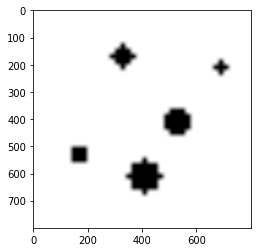

In [64]:
plt.imshow(v_map, cmap="Greys")
plt.show()

In [65]:
DIRECT_NONE = -1
ULEFT = 0   # 上段左
UCENTER = 1 # 上段中
URIGHT = 2  # 上段右
CRIGHT = 3  # 中段右
BRIGHT = 4  # 下段右
BCENTER = 5 # 下段中
BLEFT = 6   # 下段左
CLEFT = 7   # 中段左

def edgeExtraction(binimg, pt):
    height, width = binimg.shape[:2]
    xend = width - 1
    cnt = 0
    x, y = pt
    ary = []

    lflg = False
    rflg = False
    if 0 < x and binimg[y, x-1] == 255:         # 中段左
        ary.append(CLEFT)
        lflg = True
    if x < xend and binimg[y, x+1] == 255:  # 中段右
        ary.append(BRIGHT)
        rflg = True
    if 0 < y:
        if binimg[y-1, x] == 255:               # 上段中
            ary.append(UCENTER)
        else:
            if lflg == False and 0 < x and binimg[y-1, x-1] == 255: # 上段左
                ary.append(ULEFT)
            if rflg == False and x < xend and binimg[y-1, x+1] == 255:# 上段右
                ary.append(URIGHT)
    if y < height-1:
        if binimg[y+1, x] == 255:       # 下段中
            ary.append(BCENTER)
        else:
            if rflg == False and x < xend and binimg[y+1, x+1] == 255:  # 下段右
                ary.append(BRIGHT)
            if lflg == False and 0 < x and binimg[y+1, x-1] == 255: # 下段左
                ary.append(BLEFT)
    return len(ary), ary

def drawText(image, text, point):
    fontsize = 0.3
    sz  = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, fontsize, thickness=1)
    h,w = image.shape[:2]
    if point[0] < w//2:
        x = point[0] + 2
    else:
        x = point[0] - sz[0][0] - 2
    if point[1] < h//2:
        y = point[1] + sz[1] + 4
    else:
        y = point[1] - 4
    cv2.putText(image, text, (x, y), cv2.FONT_HERSHEY_SIMPLEX, fontsize, (0,0,0))

_,binimg = cv2.threshold(v_map, 125, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
notmask = cv2.bitwise_not(binimg)
notmask[0, :] = 0
notmask[-1, :] = 0
notmask[:, 0] = 0
notmask[:, -1] = 0

# 距離変換
dist_ = cv2.distanceTransform(notmask, cv2.DIST_L2, 3)
dist = cv2.normalize(dist_, None, 0, 255, cv2.NORM_MINMAX)
dist8u = dist.astype(np.uint8)
idx = dist8u > 60
dist8u[idx] = 60

# 距離変換画像を二値化
_, bin_route = cv2.threshold(dist8u, 20, 255, cv2.THRESH_BINARY)
skeleton = cv2.ximgproc.thinning(bin_route, thinningType=cv2.ximgproc.THINNING_GUOHALL)

# 入力画像と細線画像を合成
result = 255 - v_map.copy()
result = cv2.cvtColor(result, cv2.COLOR_GRAY2BGR)
result[skeleton == 255] = (255,0,0)
height, width = v_map.shape[:2]

# エッジ抽出ループ
startpoint = (0, 0)     # 移動開始位置
endpoint = (399, 299)   # 移動終了位置
points_ary = []
points_ary.append([startpoint, 0])
points_ary.append([endpoint, 9])
rt =3
for y in range(height):
    for x in range(width):
        if skeleton[y, x] == 255:
            # エッジ(分岐点とターミナル)を抽出する
            cnt, directary = edgeExtraction(skeleton, (x, y))
            if 3 <= cnt:
                points_ary.append([(x, y), 1])  # 分岐点
            elif cnt == 1:
                points_ary.append([(x, y), 2])  # ターミナル
#描画
for i, p in enumerate(points_ary):
    if p[1] == 0:   # スタートポイント
        cv2.circle(result, p[0], rt, (255,0,255), -1, lineType=cv2.LINE_AA)
        drawText(result, 'START:%d' %(i), p[0])
    elif p[1] == 1: # 交点エッジ
        cv2.circle(result, p[0], rt, (0,0,255), -1, lineType=cv2.LINE_AA)
        drawText(result, '%d' %(i), p[0])
    elif p[1] == 2: # ターミナルエッジ
        cv2.circle(result, p[0], rt, (0,255,0), -1, lineType=cv2.LINE_AA)
        drawText(result, '%d' %(i), p[0])
    elif p[1] == 9: # 終了ポイント
        cv2.circle(result, p[0], rt, (255,0,255), -1, lineType=cv2.LINE_AA)
        drawText(result, 'END:%d' %(i), p[0])

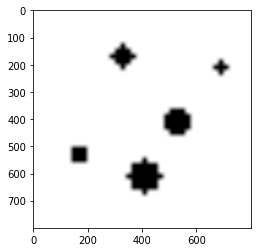

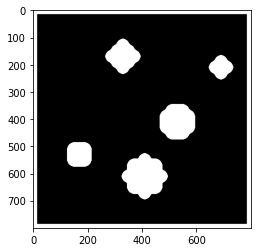

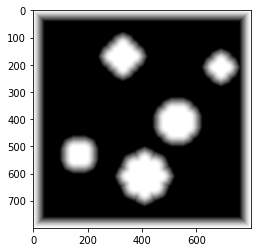

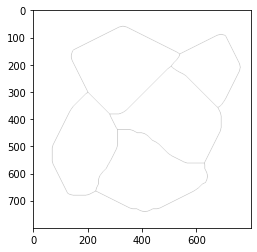

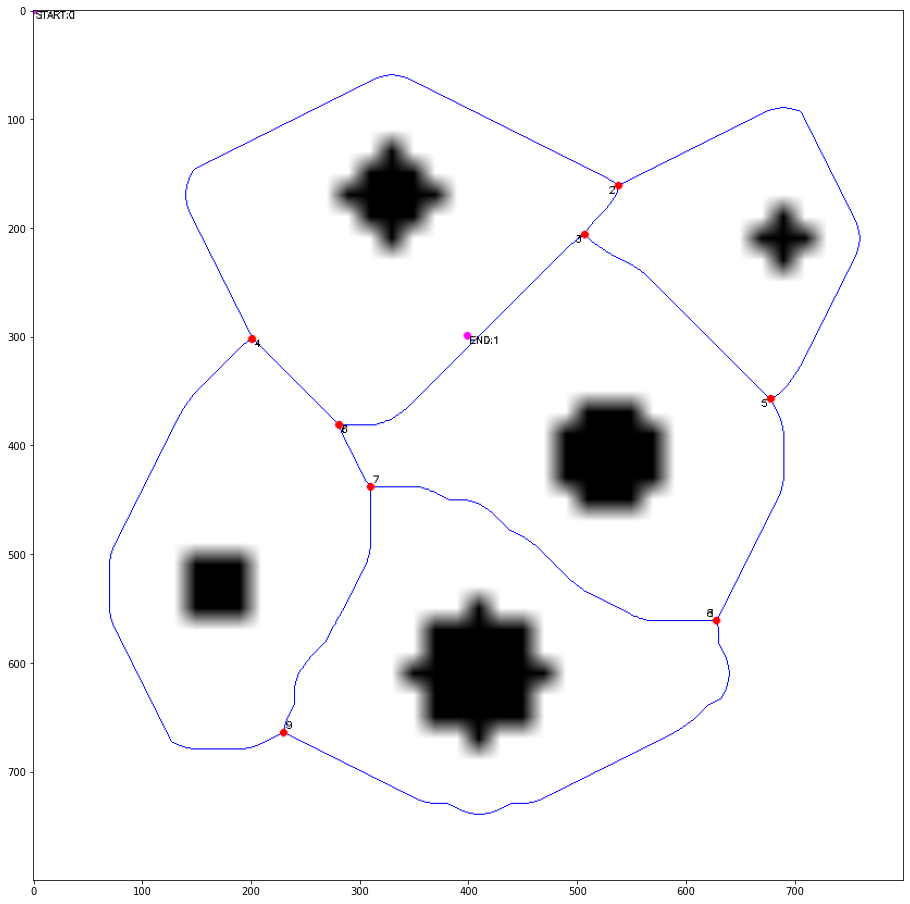

In [66]:
plt.imshow(v_map, cmap="Greys")
plt.show()

plt.imshow(bin_route, cmap="Greys")
plt.show()

plt.imshow(dist8u, cmap="Greys")
plt.show()

plt.imshow(skeleton, cmap="Greys")
plt.show()

fig, ax = plt.subplots(figsize=(16, 16))
result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
plt.imshow(result)
plt.show()